In [217]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import seaborn as sns
from sklearn.datasets import load_iris
from scipy import stats

In [225]:
iris = load_iris()
X, y = iris.data, iris.target
target_keys = ['iris-setosa', 'iris-versicolor', 'iris-virginica']
targets = np.array([target_keys[i] for i in y])
df = pd.DataFrame(X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
df['Class labels'] = targets

In [226]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [137]:
df['Sepal length']

0      5.1
1      4.9
2      4.7
3      4.6
4      5.0
      ... 
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: Sepal length, Length: 150, dtype: float64

In [138]:
df.describe()

,Sepal length,Sepal width,Petal length,Petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


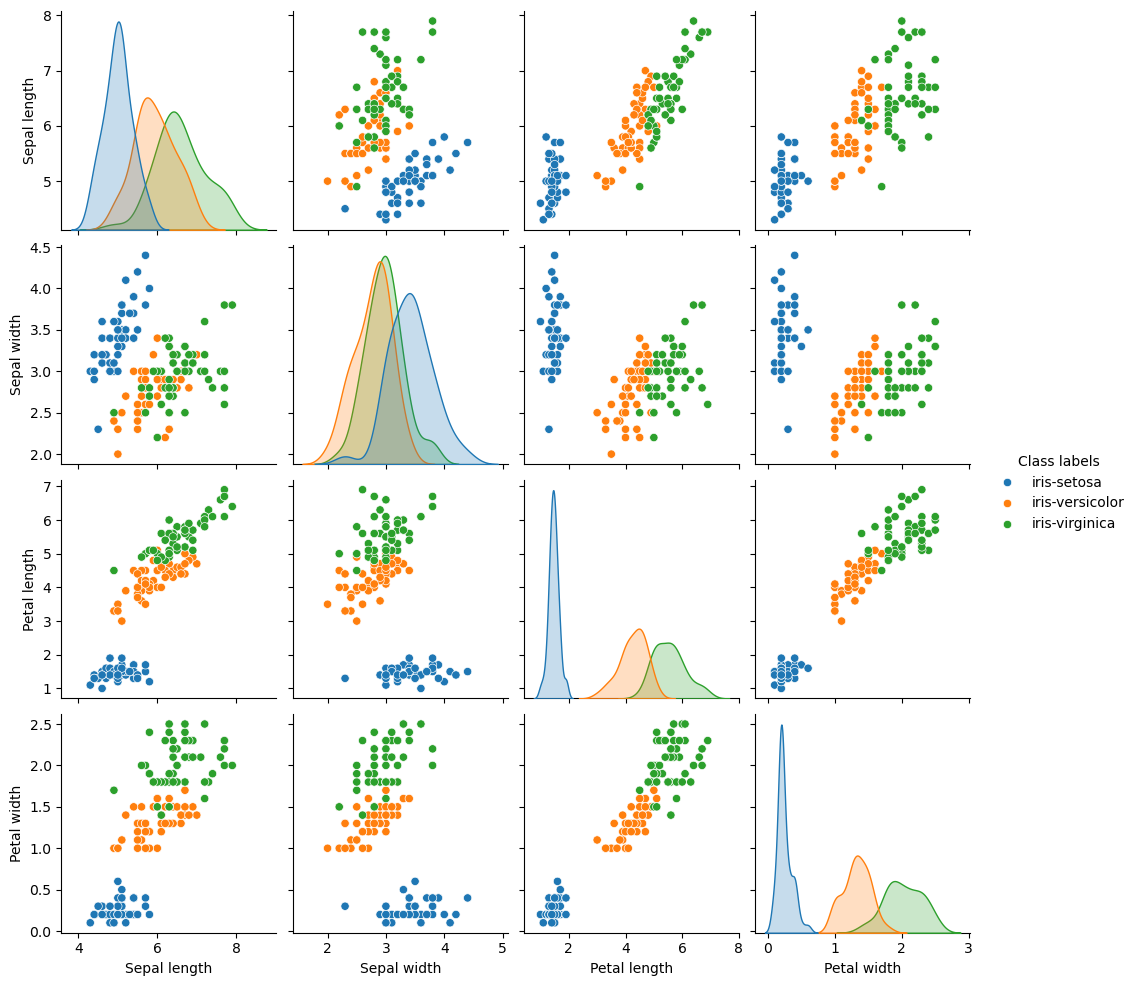

In [134]:
sns.pairplot(df, hue='Class labels')

Implement:
 - Desicion Tree
 - Random Forest
 - Support Vector Machine

4 attributes, 3 classes

Decision Tree steps:

Find the split (class & threshold) that leads to the largest inforation gain

Keep going recursively until you're at the number of desired classes

In [181]:
X.shape, np.array([y]).shape

((150, 4), (1, 150))

In [256]:
class TreeNode():
    def __init__(self, data, feature_idx, feature_val, feature_mode, information_gain, left=None, right=None) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.feature_mode = feature_mode
        # self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.left = left
        self.right = right

In [274]:
class DecisionTree():
    def __init__(self, max_depth=4, min_samples_leaf=1, min_information_gain=0.0) -> None:
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain


    def entropy(self, probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in probabilities if p>0])
    

    def split(self, data, j, feature_val) -> tuple:
        group1 = data[data[:, j] <= feature_val][:, (j, -1)]
        group2 = data[data[:, j] > feature_val][:, (j, -1)]

        return group1, group2
    

    def partition_entropy(self, l1, l2) -> float:
        labels = np.concatenate((l1, l2), 0)
    
        parent_event_probs = [labels[labels==label].shape[0] / labels.shape[0] for label in self.classes]
        left_event_probs = [l1[l1==label].shape[0] / l1.shape[0] for label in self.classes]
        right_event_probs = [l2[l2==label].shape[0] / l2.shape[0] for label in self.classes]

        parent_entropy = self.entropy(parent_event_probs)
        left_node_entropy = self.entropy(left_event_probs)
        right_node_entropy = self.entropy(right_event_probs)
        child_entropy = (l1.shape[0] * left_node_entropy + l2.shape[0] * right_node_entropy) / labels.shape[0]

        return parent_entropy - child_entropy

    
    def find_best_split(self, data: np.array) -> tuple:
        best_feature_val = [0, 0, 0]
        for j in range(data.shape[1]-1):
            dataj = data[:, j]
            for feature_val in np.linspace(min(dataj), max(dataj), num=2*np.unique(dataj).shape[0]):
                g1, g2 = self.split(data, j, feature_val)
                if g1.size > 0 and g2.size > 0:
                    info_gain = self.partition_entropy(g1[:, -1], g2[:, -1])
                    if info_gain >= best_feature_val[0]:
                        best_feature_val = [info_gain, feature_val, j]

        info_gain = best_feature_val[0]
        feature_val = best_feature_val[1]
        j = best_feature_val[2]
        left_node = data[data[:, j] <= feature_val]
        right_node = data[data[:, j] > feature_val]

        return left_node, right_node, j, feature_val, info_gain

        
    def create_tree(self, data: np.array, current_depth: int) -> TreeNode:

        if current_depth >= self.max_depth:
            return None
        
        split1, split2, feature_idx, feature_val, info_gain = self.find_best_split(data)

        node = TreeNode(data, feature_idx, feature_val, stats.mode(data[:, -1]), info_gain)

        if split1.shape[0] < self.min_samples_leaf or split2.shape[0] < self.min_samples_leaf:
            return node
        elif info_gain < self.min_information_gain:
            return node

        node.left = self.create_tree(split1, current_depth+1)
        node.right = self.create_tree(split2, current_depth+1)

        return node


    def train(self, X_train: np.array, y_train: np.array) -> None:
        self.classes = np.unique(y_train)
        train_data = np.concatenate((X_train, y_train[:, np.newaxis]), 1)
        self.tree = self.create_tree(train_data, current_depth=0)

    def predict_one_sample(self, X: np.array) -> np.array:
        node = self.tree

        while node:
            pred_class = node.feature_mode[0]
            if X[node.feature_idx] <= node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_class

    def predict(self, X_test: np.array, y_test: np.array) -> float:
        predictions = np.apply_along_axis(self.predict_one_sample, 1, X_test)
        accuracy = sum(predictions==y_test) / y_test.shape[0]
        return accuracy

    # def predict_proba(self, X_set: np.array) -> np.array:

    # def predict(self, X_set: np.array) -> np.array:

    

In [293]:
decision_tree = DecisionTree()
decision_tree.train(X, y)
decision_tree.predict(X, y)

np.float64(0.9733333333333334)

In [294]:
def print_tree(node, depth=0):
    indent = "  " * depth
    if node is None:
        print(indent + "∅")
        return

    # if leaf node
    if node.left is None and node.right is None:
        print(indent + f"Leaf: {node.feature_mode[0]}")
    else:
        print(indent + f"[X{node.feature_idx} <= {node.feature_val:.3f}]")
        print(indent + "L:")
        print_tree(node.left, depth + 1)
        print(indent + "R:")
        print_tree(node.right, depth + 1)


In [297]:
data = np.concatenate((X, y[:, np.newaxis]), 1)
data[(1, 5, 10, 30, 50, 80, 100, 120, 140), :]

array([[4.9, 3. , 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.1, 1.6, 0.2, 0. ],
       [7. , 3.2, 4.7, 1.4, 1. ],
       [5.5, 2.4, 3.8, 1.1, 1. ],
       [6.3, 3.3, 6. , 2.5, 2. ],
       [6.9, 3.2, 5.7, 2.3, 2. ],
       [6.7, 3.1, 5.6, 2.4, 2. ]])

In [296]:
print_tree(decision_tree.tree)

[X3 <= 0.993]
L:
  [X3 <= 0.555]
  L:
    [X3 <= 0.456]
    L:
      Leaf: 0.0
    R:
      Leaf: 0.0
  R:
    Leaf: 0.0
R:
  [X3 <= 1.774]
  L:
    [X2 <= 4.980]
    L:
      Leaf: 1.0
    R:
      Leaf: 2.0
  R:
    [X2 <= 4.857]
    L:
      Leaf: 2.0
    R:
      Leaf: 2.0
